이미지 크기: (512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


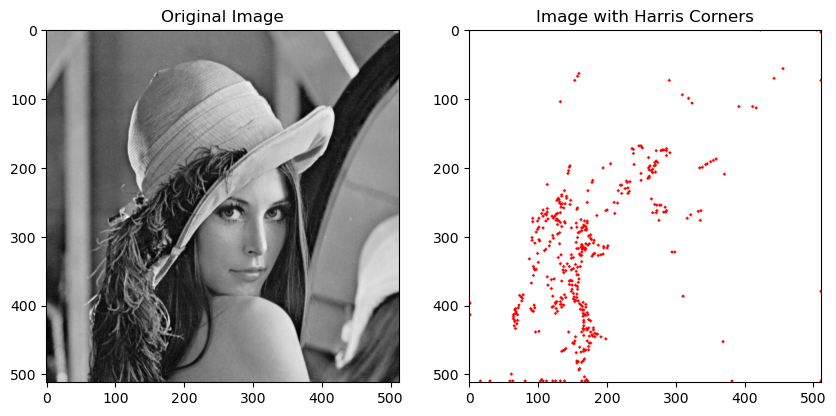

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 이미지 로드 (cv2 사용)
def load_image_as_gray(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")
    return np.array(img, dtype=np.float32)

# 2. Sobel 필터로 기울기 계산
def compute_gradients(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    h, w = image.shape
    grad_x = np.zeros((h, w))
    grad_y = np.zeros((h, w))

    padded_img = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for y in range(h):
        for x in range(w):
            grad_x[y, x] = np.sum(padded_img[y:y+3, x:x+3] * sobel_x)
            grad_y[y, x] = np.sum(padded_img[y:y+3, x:x+3] * sobel_y)

    return grad_x, grad_y

# 3. 해리스 코너 응답 계산
def harris_corner_detection(image, k=0.04, window_size=3, threshold=0.01):
    h, w = image.shape
    offset = window_size // 2

    grad_x, grad_y = compute_gradients(image)
    Ixx = grad_x ** 2
    Ixy = grad_x * grad_y
    Iyy = grad_y ** 2

    kernel = np.ones((window_size, window_size)) / (window_size ** 2)
    Sxx = np.zeros((h, w))
    Sxy = np.zeros((h, w))
    Syy = np.zeros((h, w))

    padded_Ixx = np.pad(Ixx, ((offset, offset), (offset, offset)), mode='constant')
    padded_Ixy = np.pad(Ixy, ((offset, offset), (offset, offset)), mode='constant')
    padded_Iyy = np.pad(Iyy, ((offset, offset), (offset, offset)), mode='constant')

    for y in range(h):
        for x in range(w):
            Sxx[y, x] = np.sum(padded_Ixx[y:y+window_size, x:x+window_size] * kernel)
            Sxy[y, x] = np.sum(padded_Ixy[y:y+window_size, x:x+window_size] * kernel)
            Syy[y, x] = np.sum(padded_Iyy[y:y+window_size, x:x+window_size] * kernel)

    det_M = Sxx * Syy - Sxy ** 2
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    R_max = np.max(np.abs(R))
    if R_max != 0:
        R = R / R_max
    R[R < threshold] = 0

    return R

# 4. 비최대 억제
def non_max_suppression(R, window_size=3):
    offset = window_size // 2
    h, w = R.shape
    R_suppressed = R.copy()

    padded_R = np.pad(R, ((offset, offset), (offset, offset)), mode='constant')
    for y in range(h):
        for x in range(w):
            window = padded_R[y:y+window_size, x:x+window_size]
            if R[y, x] != np.max(window):
                R_suppressed[y, x] = 0

    return R_suppressed

# 5. 코너 위치를 원본 이미지에 오버레이
def overlay_corners_on_image(original_img, corner_response):
    # 컬러 이미지로 변환 (Matplotlib은 RGB 형식을 사용)
    original_color = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
    
    # 코너 위치 추출 (R 값이 0이 아닌 곳)
    corners_y, corners_x = np.where(corner_response > 0)
    
    # 코너 위치에 빨간 점 그리기
    for y, x in zip(corners_y, corners_x):
        # 원형 마커 그리기 (반지름 2로 설정)
        cv2.circle(original_color, (x, y), 2, (255, 0, 0), -1)  # 빨간색 (RGB)

    return original_color

# 6. 결과 시각화
def plot_results(original_img, overlay_img):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Image with Harris Corners")
    plt.imshow(overlay_img)  # RGB 이미지를 직접 표시
    plt.show()

# 7. 메인 실행
if __name__ == "__main__":
    image_path = "./image/lena.bmp"  # 실제 이미지 경로로 변경
    gray_image = load_image_as_gray(image_path)
    print(f"이미지 크기: {gray_image.shape}")
    
    # 해리스 코너 검출
    window_size = 3
    k = 0.04
    threshold = 0.01  # 필요 시 조정
    corner_response = harris_corner_detection(gray_image, k, window_size, threshold)
    
    # 비최대 억제 적용
    corner_response = non_max_suppression(corner_response, window_size)
    
    # 코너 오버레이
    overlay_image = overlay_corners_on_image(gray_image, corner_response)
    
    # 결과 시각화
    plot_results(gray_image, overlay_image)